<a href="https://colab.research.google.com/github/sungjuGit/STPython_IntroBayes/blob/main/GP_Intro_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted from the Julia code by Claude.ai

In [ ]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [ ]:
# Set random seed
rng = RandomState(1234)

# Small value for numerical stability
epsilon = 1.0e-6

def SE_kernel(x, x_prime, lambda_=1, l=1):
    """Squared exponential kernel function"""
    return (lambda_**2) * np.exp(-(x - x_prime)**2 / (2 * (l**2)))

def self_cov_mat(kernel, X):
    """Compute covariance matrix for the given points"""
    length = len(X)
    K = np.zeros((length, length))

    for i in range(length):
        for j in range(i, length):
            K[i, j] = kernel(X[i], X[j])
            K[j, i] = K[i, j]

    # Add small diagonal term for numerical stability
    return K + epsilon * np.eye(length)

def cross_cov_mat(kernel, X, X_prime):
    """Compute cross-covariance matrix between two sets of points"""
    size = len(X)
    size_prime = len(X_prime)
    K = np.zeros((size, size_prime))

    for i in range(size):
        for j in range(size_prime):
            K[i, j] = kernel(X[i], X_prime[j])

    return K

def sample_prior(xs, num_samples, kernel):
    """Sample from the prior distribution"""
    mu = np.zeros(len(xs))
    Sigma = self_cov_mat(kernel, xs)

    # Sample from multivariate normal distribution
    ys = np.random.multivariate_normal(mu, Sigma, num_samples).T

    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(xs, ys[:, i])
    plt.title("Samples from Prior Distribution")
    plt.show()

    return ys

def predictive_gp(X, y, Xs, kernel):
    """Compute predictive distribution for Gaussian Process"""
    KXX = self_cov_mat(kernel, X)
    KXsX = cross_cov_mat(kernel, Xs, X)
    KXsXs = self_cov_mat(kernel, Xs)

    # Compute predictive mean and covariance
    mu_pred = KXsX @ np.linalg.inv(KXX) @ y
    K_pred = KXsXs - KXsX @ np.linalg.inv(KXX) @ KXsX.T

    # Ensure symmetry
    K_pred = (K_pred + K_pred.T) / 2

    return mu_pred, K_pred

def sample_predictive(x_train, y_train, x_pred, num_samples, kernel):
    """Sample from the predictive distribution"""
    mu, K = predictive_gp(x_train, y_train, x_pred, kernel)

    # Sample from multivariate normal
    ys = np.random.multivariate_normal(mu, K, num_samples).T

    # Standard deviations for confidence intervals
    sigmas = np.sqrt(np.diag(K))

    return ys, sigmas



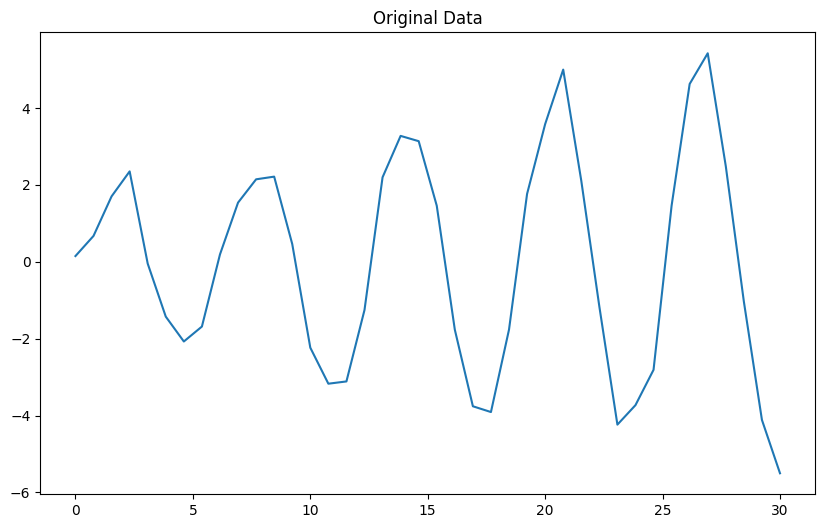

In [ ]:
# Generate toy dataset
num_sample = 40
num_train = 30

x = np.linspace(0, 30, num_sample)
epsilon_data = rng.normal(0, 0.5, num_sample)
y = np.sqrt(x) * np.sin(x) + epsilon_data

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Original Data")
plt.show()


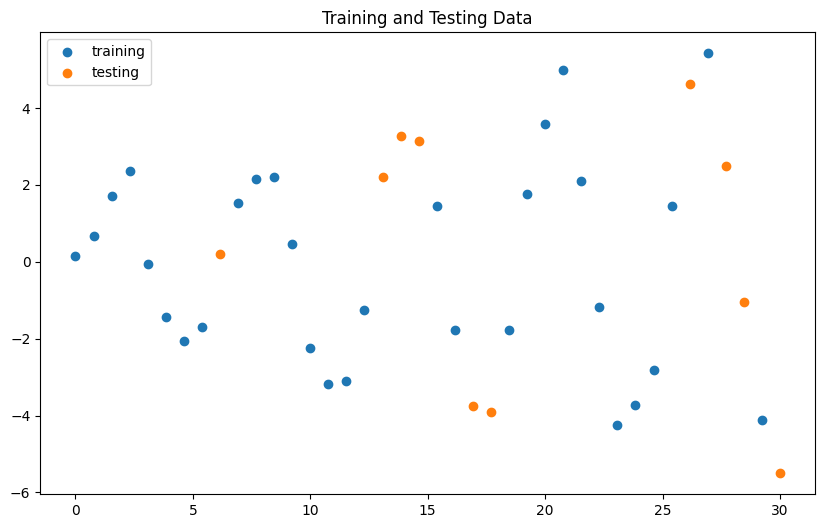

In [ ]:
# Split into training and test sets
indices = rng.permutation(num_sample)
x_train = np.zeros(num_train)
y_train = np.zeros(num_train)
x_test = np.zeros(num_sample - num_train)
y_test = np.zeros(num_sample - num_train)

for i, val in enumerate(indices):
    if i < num_train:
        x_train[i] = x[val]
        y_train[i] = y[val]
    else:
        x_test[i - num_train] = x[val]
        y_test[i - num_train] = y[val]

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label="training")
plt.scatter(x_test, y_test, label="testing")
plt.legend()
plt.title("Training and Testing Data")
plt.show()

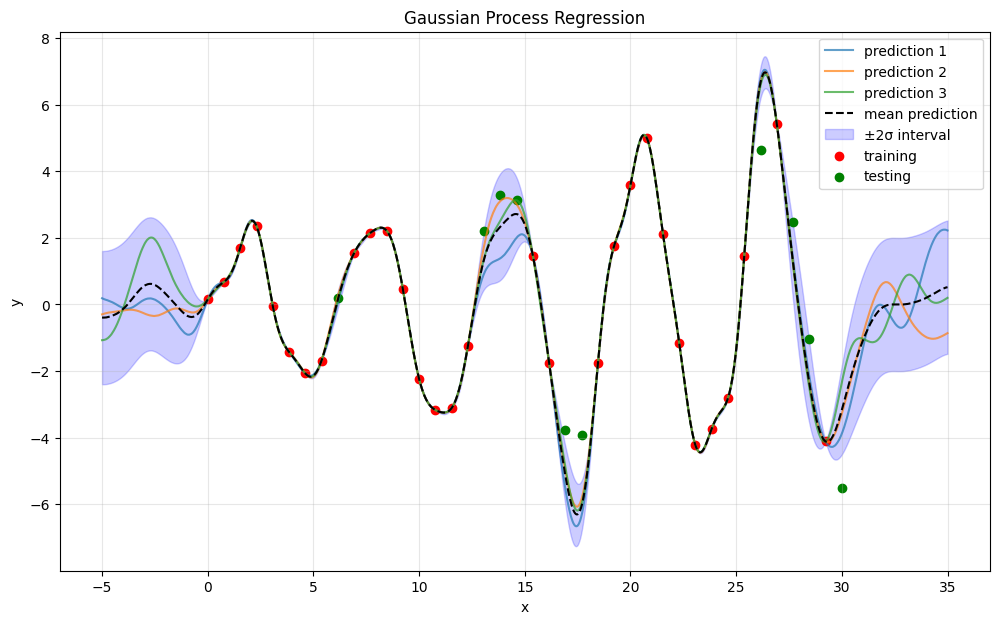

In [ ]:
# Make predictions
x_pred = np.linspace(-5, 35, 1000)
y_pred, sigma_pred = sample_predictive(x_train, y_train, x_pred, 3, SE_kernel)

plt.figure(figsize=(12, 7))
for i in range(3):
    plt.plot(x_pred, y_pred[:, i], alpha=0.7, label=f"prediction {i+1}")

# Plot mean prediction with confidence intervals
mean_pred = np.mean(y_pred, axis=1)
plt.plot(x_pred, mean_pred, 'k--', label="mean prediction")
plt.fill_between(x_pred, mean_pred - 2*sigma_pred, mean_pred + 2*sigma_pred,
                 alpha=0.2, color='blue', label="±2σ interval")

plt.scatter(x_train, y_train, color='red', label="training")
plt.scatter(x_test, y_test, color='green', label="testing")
plt.legend()
plt.title("Gaussian Process Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, alpha=0.3)
plt.show()